In [50]:
import numpy as np
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import Actions
from gym_anytrading.envs import ForexEnv, StocksEnv

# stable-baselines3
from stable_baselines3 import A2C
from stable_baselines3.common.env_util import make_vec_env
warnings.filterwarnings('ignore')
import quantstats as qs
from dotenv import load_dotenv
import os
plt.style.use('ggplot')
load_dotenv()

True

In [58]:
client = oandapyV20.API(access_token=os.getenv("OANDA_ACCESS_TOKEN"))

params = {'granularity': 'M1', 'count': 1440}
r = instruments.InstrumentsCandles(instrument="GBP_USD",
                                   params=params)
client.request(r)

data = [{'Time': d['time'], # time is in UTC by default
         'High': d['mid']['h'], 
         'Close': d['mid']['c'], 
         'Low': d['mid']['l'], 
         'Open': d['mid']['o'], 
         'Volume': d['volume']} 
        for d in r.response['candles']]

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(data)
df[['High', 'Close', 'Low', 'Open', 'Volume']] = df[['High', 'Close', 'Low', 'Open', 'Volume']].apply(pd.to_numeric)

In [59]:
(
    df.assign(changes=df.Close.diff())
)

,Time,High,Close,Low,Open,Volume,changes
0,2024-03-29T10:38:00.000000000Z,1.26196,1.26182,1.26181,1.26194,45,NaN
1,2024-03-29T10:39:00.000000000Z,1.26180,1.26168,1.26168,1.26180,31,-0.00014
2,2024-03-29T10:40:00.000000000Z,1.26176,1.26171,1.26168,1.26168,14,0.00003
3,2024-03-29T10:41:00.000000000Z,1.26172,1.26170,1.26167,1.26170,38,-0.00001
4,2024-03-29T10:42:00.000000000Z,1.26172,1.26170,1.26168,1.26168,27,0.00000
...,...,...,...,...,...,...,...
1435,2024-04-01T11:33:00.000000000Z,1.26142,1.26139,1.26136,1.26142,39,-0.00005
1436,2024-04-01T11:34:00.000000000Z,1.26153,1.26150,1.26134,1.26138,47,0.00011
1437,2024-04-01T11:35:00.000000000Z,1.26160,1.26158,1.26146,1.26148,38,0.00008
1438,2024-04-01T11:36:00.000000000Z,1.26158,1.26157,1.26156,1.26158,33,-0.00001


In [61]:
window_size = 5
env = gym.make('forex-v0', df=df, frame_bound=(window_size,int(len(df)*0.8)), window_size=window_size, unit_side='right')

In [62]:
print("env information:")
print("> shape:", env.unwrapped.shape)
print("> df.shape:", env.unwrapped.df.shape)
print("> prices.shape:", env.unwrapped.prices.shape)
print("> signal_features.shape:", env.unwrapped.signal_features.shape)
print("> max_possible_profit:", env.unwrapped.max_possible_profit())

env information:
> shape: (5, 2)
> df.shape: (1440, 6)
> prices.shape: (1152,)
> signal_features.shape: (1152, 2)
> max_possible_profit: 0.9628684907378882


In [63]:
env.action_space # only buy and sell, it doesnt support hold

Discrete(2)

In [64]:
action = env.action_space.sample()

In [65]:
observation = env.reset(seed=2024)
while True:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        print("info:", info)
        break

info: {'total_reward': -30.612945556640625, 'total_profit': 0.9347532033069129, 'position': <Positions.Short: 0>}


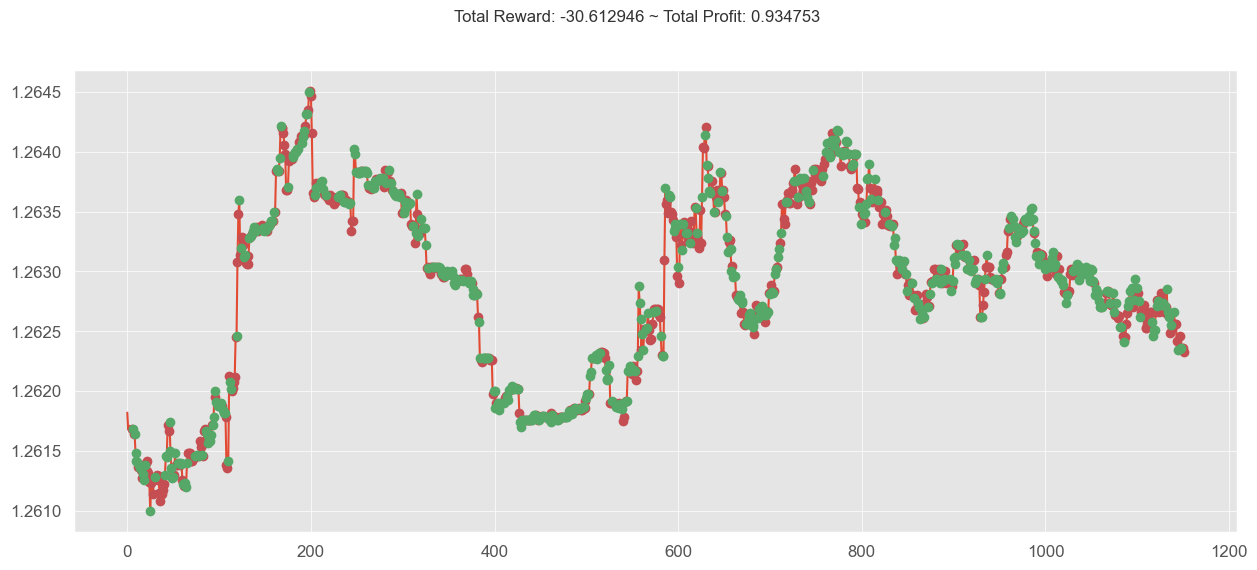

In [66]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

In [67]:
env.reset(seed=2023)
model = A2C('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=10000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| time/                 |          |
|    fps                | 2968     |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.0908  |
|    explained_variance | 0.452    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 5.41e-07 |
|    value_loss         | 9.88e-10 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 3066     |
|    iterations         | 200      |
|    time_elapsed       | 0        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.0618  |
|    explained_variance | -2.54    |
|    learning_rate      | 0.0007   |
|    n_updates    

In [68]:
action_stats = {Actions.Sell: 0, Actions.Buy: 0}
env = gym.make('forex-v0', df=df, frame_bound=(int(len(df)*0.8), len(df)), window_size=window_size, unit_side='right')
observation, info = env.reset(seed=2023)

while True:
    # action = env.action_space.sample()
    action, _states = model.predict(observation)

    action_stats[Actions(action)] += 1
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        break

env.close()

print("action_stats:", action_stats)
print("info:", info)

action_stats: {<Actions.Sell: 0>: 235, <Actions.Buy: 1>: 52}
info: {'total_reward': 6.695985794067383, 'total_profit': 0.9900007765089357, 'position': <Positions.Short: 0>}


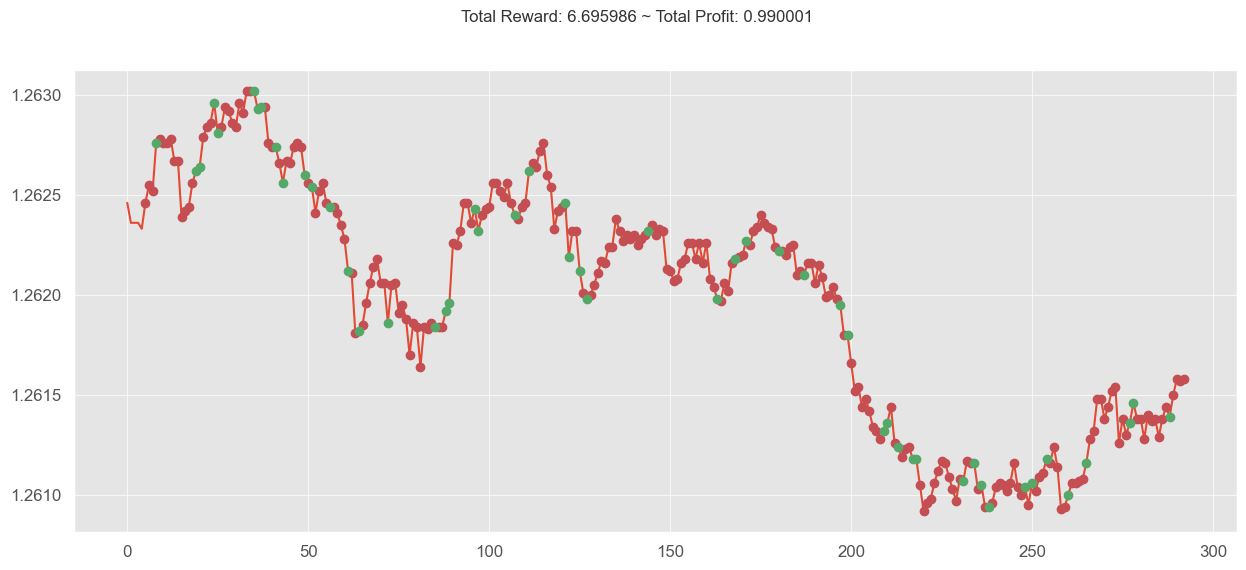

In [69]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()